# Real-World Example: Hydrographic Trends in the Baltic Sea

We'll see that in an Ocean model covering the Baltic Sea, there is a long-term trend for the basin- wide hydrography which is overlayed by decadal variability in the deepest parts of the Gotland Basin.

## First of all, spin up the dask cluster

(This is not necessary, but allows for checking details of the parallelized computation we'll perform below.)

In [1]:
from dask.distributed import Client

In [2]:
client = Client(
    n_workers=1,           # on a shared-memory machine, prefer fewer workers
    threads_per_worker=4,  # with more threads
    memory_limit=1e9       # Memory limit is 1GB per worker
)

In [3]:
client

Client Scheduler: tcp://127.0.0.1:42505 Dashboard: /user/geomar-tm-python-intro-201804-6o50nxxb/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 1000.00 MB


**Click on the _Dashboard_ link above!**

## Load relevant modules and make sure figures look nice

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
sns.set_style("darkgrid")
sns.set_context("notebook")

## Then, load the data and crop them to the Baltic Sea

This is where you decide which backend Xarray will use.  Specify `chunks={...}` when opening the data set to use the parallelized Dask backend.

In [7]:
file_name = "data/baltic_hydrography/INSPIRE_1979_2016_annual_oce_surf_and_bottom_hydrograhy.nc"

ds = xr.open_dataset(file_name,
                     chunks={"time": 19, "lat": 150, "lon": 150})

ds = ds.sel(lon=slice(9, None))  # East of 9°E

display(ds)

<xarray.Dataset>
Dimensions:  (lat: 538, lon: 475, time: 38)
Coordinates:
  * lon      (lon) float32 9.0225 9.0675 9.1125 ... 30.2625 30.3075 30.3525
  * lat      (lat) float32 53.8225 53.845 53.8675 53.89 ... 65.86 65.8825 65.905
  * time     (time) datetime64[ns] 1979-12-31 1980-12-31 ... 2016-12-31
Data variables:
    BTEMP    (time, lat, lon) float32 dask.array<shape=(38, 538, 475), chunksize=(19, 150, 39)>
    SSS      (time, lat, lon) float32 dask.array<shape=(38, 538, 475), chunksize=(19, 150, 39)>
    BSALT    (time, lat, lon) float32 dask.array<shape=(38, 538, 475), chunksize=(19, 150, 39)>
    SST      (time, lat, lon) float32 dask.array<shape=(38, 538, 475), chunksize=(19, 150, 39)>
Attributes:
    history:  Created from monthly INSPIRE fields weighting all months equally.

## Have a look: Data ranges

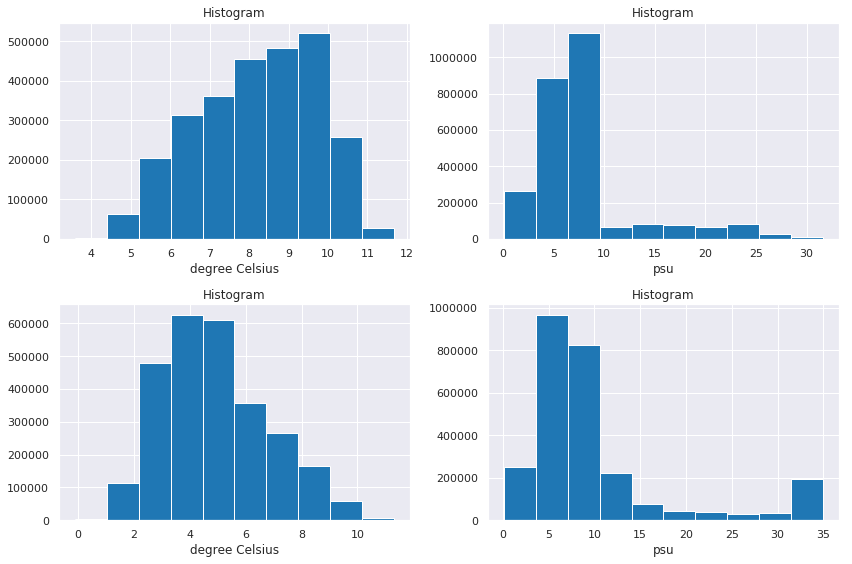

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

for iter_ax, vname in zip(ax.flat, ["SST", "SSS", "BTEMP", "BSALT"]):
    
    # plot histogram for each variable
    ds[vname].compute().plot.hist(ax=iter_ax);
    
    # add meaning to the horizontal axis
    iter_ax.set_xlabel(ds[vname].units)

fig.tight_layout()

## Produce a map projection with the data

We use [cartopy](http://scitools.org.uk/cartopy/docs/latest/) to create a map with land masses and borders.

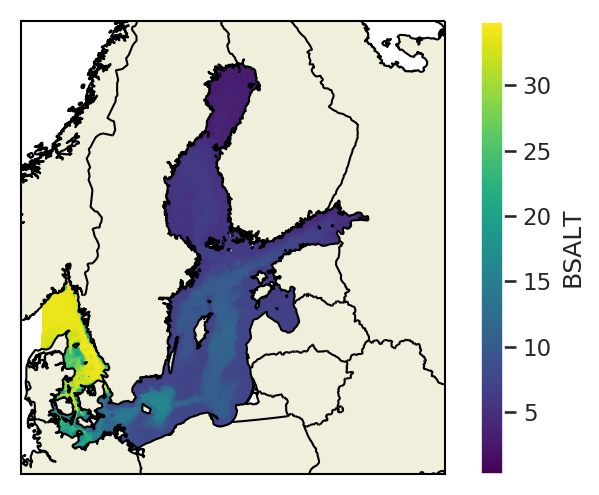

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as feature

plt.rcParams["figure.dpi"] = 150

ax = plt.axes(projection=ccrs.Orthographic(10, 54))

ds.BSALT.mean("time").compute().plot(ax=ax,
                                     transform=ccrs.PlateCarree())

land_masses = feature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='k',
    facecolor=feature.COLORS['land'])
ax.add_feature(land_masses)

borders = feature.NaturalEarthFeature(
    'cultural', 'admin_0_boundary_lines_land', '10m',
    edgecolor='k',
    facecolor='none')
ax.add_feature(borders);

## Calculating linear trends

We exploit the fact that for $y = m\,x + n$ with independent $x$, we can estimate:

$$\hat{m} = \frac{{\rm cov}(y, x)}{{\rm var}(x)}$$
$$\hat{n} = \bar{y} - \hat{m} \, \bar{x}$$

In [11]:
def get_time_in_years(time):
    
    one_year = 365 * 24 * 3600 * np.timedelta64(1, 's')
    
    return ((time - time[0]) / one_year).astype("float")

In [12]:
def get_slope(data):
    
    time = get_time_in_years(data.coords["time"])
    
    slope = (
        ((data - data.mean("time")) * (time - time.mean("time"))).sum("time")
        / ((time - time.mean("time")) ** 2).sum("time")
    )
    
    return slope

In [13]:
def get_intercept(data):
    
    slope = get_slope(data)
    
    time = get_time_in_years(data.coords["time"])
    intercept = data.mean("time") - slope * time.mean("time")
        
    return intercept

In [14]:
def get_linear_trend(data):
    
    time = get_time_in_years(data.coords["time"])
    slope = get_slope(data)
    intercept = get_intercept(data)
    
    trend = slope * time + intercept
    
    trend.coords["time"] = data.coords["time"]
    
    return trend

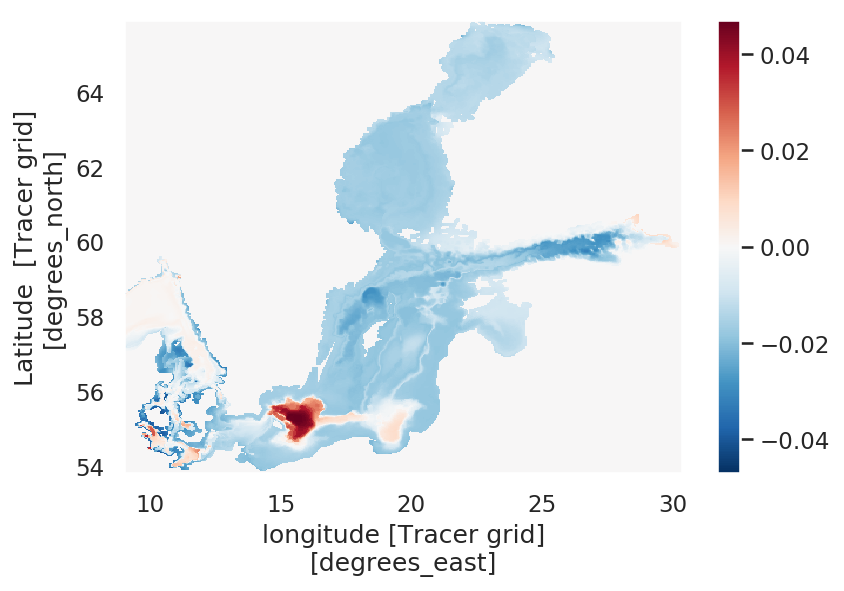

In [15]:
get_slope(ds.BSALT).compute().plot(rasterized=True);  # rasterize for smaller image sizes

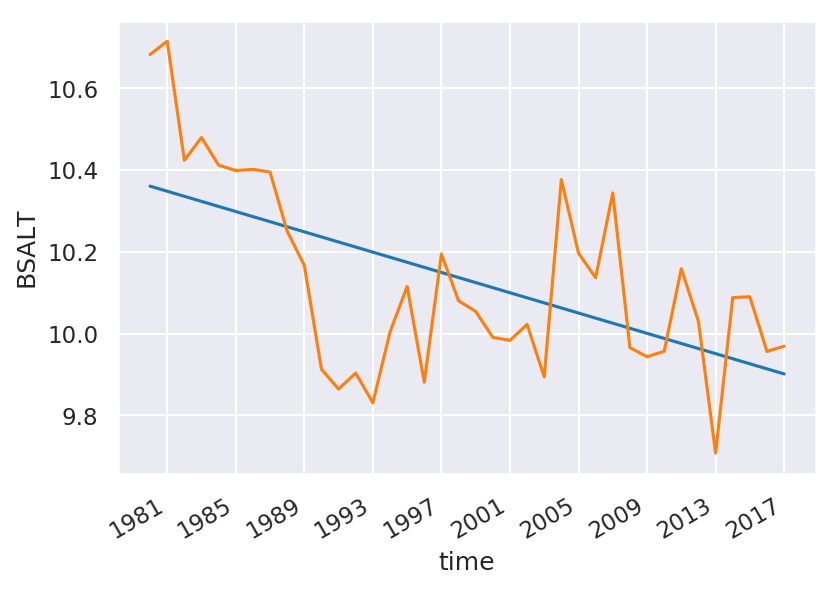

In [17]:
get_linear_trend(ds.BSALT.mean(dim=("lat", "lon"))).compute().plot();
ds.BSALT.mean(dim=("lat", "lon")).compute().plot();